In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely import affinity
from shapely.ops import unary_union

print("Imports done.")

Imports done.


## Create Test Polygons

We'll use a triangle and a pentagon as our test shapes.

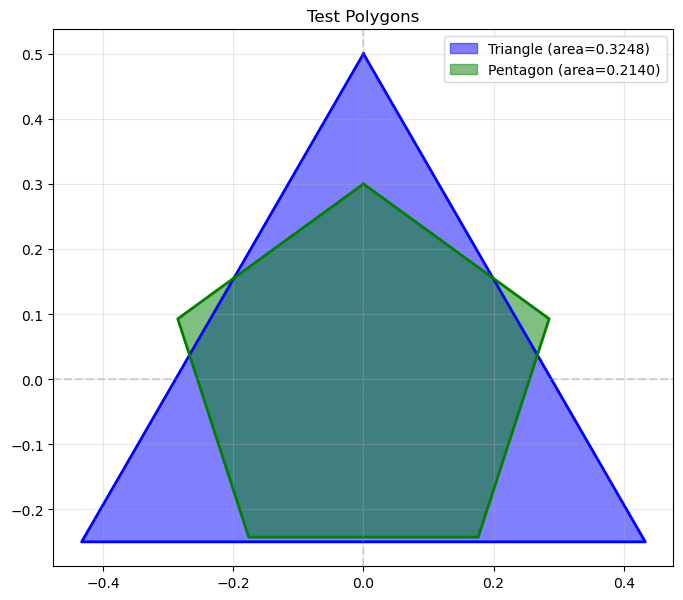

Triangle vertices: [(3.061616997868383e-17, 0.5), (-0.4330127018922194, -0.24999999999999986), (0.4330127018922192, -0.2500000000000002)]
Pentagon vertices: [(1.8369701987210297e-17, 0.3), (-0.285316954888546, 0.09270509831248425), (-0.17633557568774197, -0.24270509831248419), (0.17633557568774186, -0.24270509831248427), (0.2853169548885461, 0.09270509831248415)]


In [12]:
def create_regular_polygon(n_sides: int, radius: float = 1.0, rotation: float = 0.0) -> Polygon:
    """Create a regular polygon centered at origin."""
    angles = np.linspace(0, 2*np.pi, n_sides, endpoint=False) + rotation
    coords = [(radius * np.cos(a), radius * np.sin(a)) for a in angles]
    return Polygon(coords)

# Create a triangle and a pentagon
triangle = create_regular_polygon(3, radius=0.5, rotation=np.pi/2)  # Point up
pentagon = create_regular_polygon(5, radius=0.3, rotation=np.pi/2)

# Visualize
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

x, y = triangle.exterior.xy
ax.fill(x, y, alpha=0.5, color='blue', label=f'Triangle (area={triangle.area:.4f})')
ax.plot(x, y, 'b-', linewidth=2)

x, y = pentagon.exterior.xy
ax.fill(x, y, alpha=0.5, color='green', label=f'Pentagon (area={pentagon.area:.4f})')
ax.plot(x, y, 'g-', linewidth=2)

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax.legend()
ax.set_title('Test Polygons')
ax.grid(True, alpha=0.3)
plt.show()

print(f"Triangle vertices: {list(triangle.exterior.coords)[:-1]}")
print(f"Pentagon vertices: {list(pentagon.exterior.coords)[:-1]}")

## Minkowski Sum Algorithm

For the Minkowski sum $M(A, B) = \{a + b : a \in A, b \in B\}$:

**Key insight:** $M(A, B) = \bigcup_{v \in vertices(B)} (A + v)$

That is, translate A by each vertex of B, then take the union.

In [ ]:
from shapely.geometry import Polygon, MultiPoint
from shapely.ops import unary_union

def _polygon_vertices(poly: Polygon):
    """
    Return unique exterior vertices (without the duplicated closing point).
    """
    coords = list(poly.exterior.coords)
    if len(coords) >= 2 and coords[0] == coords[-1]:
        coords = coords[:-1]
    return coords

def minkowski_difference(A: Polygon, B: Polygon, *, ensure_convex: bool = True) -> Polygon:
    """
    Compute C = A ⊕ (-B), i.e. the set of translations t such that
    A intersects (B translated by t) is non-empty.

    For convex polygons, C is convex and can be computed exactly as the convex hull
    of all pairwise sums of vertices of A and (-B).

    Notes:
    - This corresponds to "overlap" including boundary contact (intersection non-empty).
    - If A or B are not convex, set ensure_convex=False and/or convexify them yourself,
      but then this vertex-sum+convex-hull method is not generally correct for non-convex.
    """
    if ensure_convex:
        A = A.convex_hull
        B = B.convex_hull

    A_verts = _polygon_vertices(A)
    B_verts = _polygon_vertices(B)

    # Reflect B through the origin: -B
    Bneg_verts = [(-x, -y) for (x, y) in B_verts]

    # Minkowski sum of convex polygons: convex hull of pairwise vertex sums
    pts = [(ax + bx, ay + by) for (ax, ay) in A_verts for (bx, by) in Bneg_verts]
    return MultiPoint(pts).convex_hull


print("Minkowski functions defined.")

Minkowski functions defined.


## Compute and Visualize Minkowski Sum

Minkowski sum M(triangle, -pentagon):
  Area: 1.273247
  Expected: should be larger than triangle alone
  Triangle area: 0.324760
  Pentagon area: 0.213988


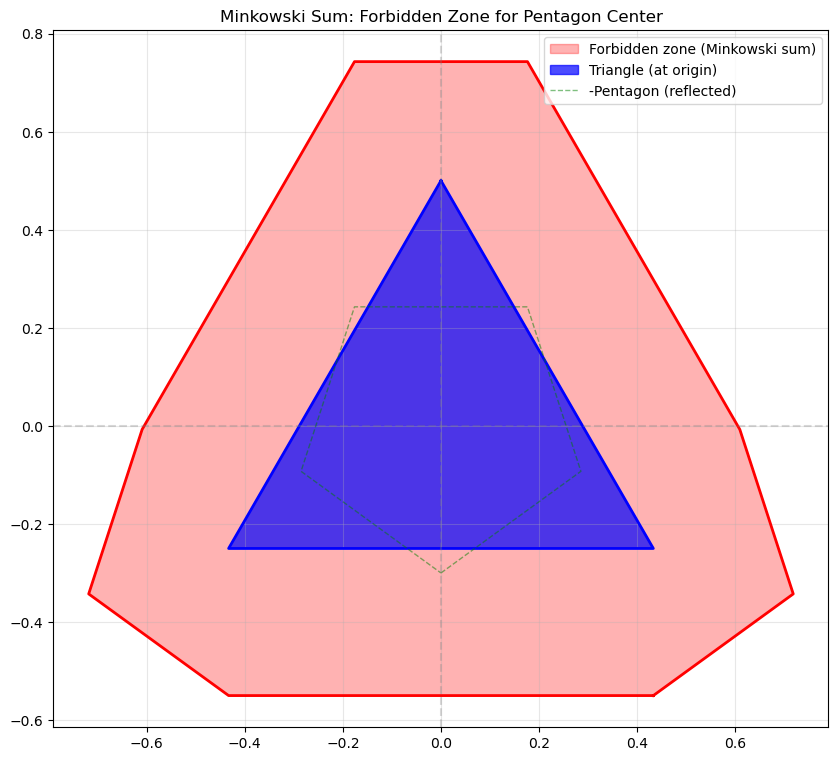

In [25]:
# Compute Minkowski difference (for collision detection)
# M(triangle, -pentagon) = forbidden zone for pentagon center when triangle is at origin
msum = minkowski_difference(triangle, pentagon)

print(f"Minkowski sum M(triangle, -pentagon):")
print(f"  Area: {msum.area:.6f}")
print(f"  Expected: should be larger than triangle alone")
print(f"  Triangle area: {triangle.area:.6f}")
print(f"  Pentagon area: {pentagon.area:.6f}")

# Visualize the Minkowski sum
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

# Plot Minkowski sum (forbidden zone)
if isinstance(msum, MultiPolygon):
    for geom in msum.geoms:
        x, y = geom.exterior.xy
        ax.fill(x, y, alpha=0.3, color='red')
        ax.plot(x, y, 'r-', linewidth=2)
else:
    x, y = msum.exterior.xy
    ax.fill(x, y, alpha=0.3, color='red', label='Forbidden zone (Minkowski sum)')
    ax.plot(x, y, 'r-', linewidth=2)

# Plot triangle at origin
x, y = triangle.exterior.xy
ax.fill(x, y, alpha=0.7, color='blue', label='Triangle (at origin)')
ax.plot(x, y, 'b-', linewidth=2)

# Plot reflected pentagon (for reference)
reflected_pent = reflect_polygon(pentagon)
x, y = reflected_pent.exterior.xy
ax.plot(x, y, 'g--', linewidth=1, alpha=0.5, label='-Pentagon (reflected)')

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
ax.legend(loc='upper right')
ax.set_title('Minkowski Sum: Forbidden Zone for Pentagon Center')
ax.grid(True, alpha=0.3)
plt.show()

## Verify: Test Points Inside, On, and Outside the Boundary

In [15]:
def find_boundary_point(msum, angle: float):
    """Find point on Minkowski boundary at given angle from origin."""
    from shapely.geometry import LineString
    
    ray_length = 5.0
    ray_end = (ray_length * np.cos(angle), ray_length * np.sin(angle))
    ray = LineString([(0, 0), ray_end])
    
    if isinstance(msum, MultiPolygon):
        boundary = unary_union([g.exterior for g in msum.geoms])
    else:
        boundary = msum.exterior
    
    intersection = ray.intersection(boundary)
    
    if intersection.is_empty:
        return None
    
    if intersection.geom_type == 'Point':
        return (intersection.x, intersection.y)
    elif intersection.geom_type == 'MultiPoint':
        points = list(intersection.geoms)
        closest = min(points, key=lambda p: p.distance(Point(0, 0)))
        return (closest.x, closest.y)
    else:
        coords = list(intersection.coords)
        return coords[0]


def verify_minkowski_accuracy(poly_a, poly_b, msum, test_angles=None, epsilon=1e-6):
    """
    Verify that the Minkowski sum correctly predicts overlaps.
    
    For each test angle:
    - Find point on boundary
    - Test points just inside, on, and just outside
    - Check if Minkowski prediction matches actual overlap
    """
    if test_angles is None:
        test_angles = np.linspace(0, 2*np.pi, 13)[:-1]  # 12 angles
    
    results = []
    
    for angle in test_angles:
        boundary_pt = find_boundary_point(msum, angle)
        if boundary_pt is None:
            continue
        
        bx, by = boundary_pt
        dist = np.sqrt(bx**2 + by**2)
        if dist < 1e-10:
            continue
        
        ux, uy = bx/dist, by/dist
        
        # Test points
        test_cases = [
            ('inside', (bx - epsilon*ux, by - epsilon*uy)),
            ('on', (bx, by)),
            ('outside', (bx + epsilon*ux, by + epsilon*uy)),
        ]
        
        for position, (px, py) in test_cases:
            # Place poly_b at this position
            poly_b_placed = affinity.translate(poly_b, xoff=px, yoff=py)
            
            # Check actual overlap
            intersection = poly_a.intersection(poly_b_placed)
            overlap_area = intersection.area
            actually_overlaps = overlap_area > 1e-12
            
            # Check Minkowski prediction
            in_msum = msum.contains(Point(px, py))
            
            # For boundary points, also check touches
            on_boundary = msum.exterior.distance(Point(px, py)) < epsilon * 2
            
            results.append({
                'angle_deg': np.degrees(angle),
                'position': position,
                'x': px,
                'y': py,
                'in_minkowski': in_msum,
                'on_boundary': on_boundary,
                'overlap_area': overlap_area,
                'actually_overlaps': actually_overlaps,
            })
    
    return results


# Run verification
results = verify_minkowski_accuracy(triangle, pentagon, msum, epsilon=1e-6)

print("Verification Results:")
print("-" * 100)
print(f"{'Angle':>8} {'Position':>10} {'In Mink':>10} {'On Bndry':>10} {'Overlaps':>10} {'Overlap Area':>15} {'Status':>8}")
print("-" * 100)

all_correct = True
for r in results:
    # Expected behavior:
    # - inside: should be in Minkowski AND should overlap
    # - on: borderline case
    # - outside: should NOT be in Minkowski AND should NOT overlap
    
    if r['position'] == 'inside':
        correct = r['in_minkowski'] and r['actually_overlaps']
    elif r['position'] == 'outside':
        correct = (not r['in_minkowski']) and (not r['actually_overlaps'])
    else:  # on boundary - can go either way
        correct = True
    
    status = '✓' if correct else '✗'
    if not correct:
        all_correct = False
    
    print(f"{r['angle_deg']:>8.1f} {r['position']:>10} {str(r['in_minkowski']):>10} {str(r['on_boundary']):>10} {str(r['actually_overlaps']):>10} {r['overlap_area']:>15.2e} {status:>8}")

print("-" * 100)
print(f"All correct: {all_correct}")

Verification Results:
----------------------------------------------------------------------------------------------------
   Angle   Position    In Mink   On Bndry   Overlaps    Overlap Area   Status
----------------------------------------------------------------------------------------------------
     0.0     inside       True       True       True        1.98e-12        ✓
     0.0         on      False       True      False        0.00e+00        ✓
     0.0    outside      False       True      False        0.00e+00        ✓
    30.0     inside       True       True       True        2.64e-12        ✓
    30.0         on      False       True      False        0.00e+00        ✓
    30.0    outside      False       True      False        0.00e+00        ✓
    60.0     inside       True       True       True        1.98e-12        ✓
    60.0         on      False       True      False        0.00e+00        ✓
    60.0    outside      False       True      False        0.00e+00      

## Visual Verification: Show Trees at Test Points

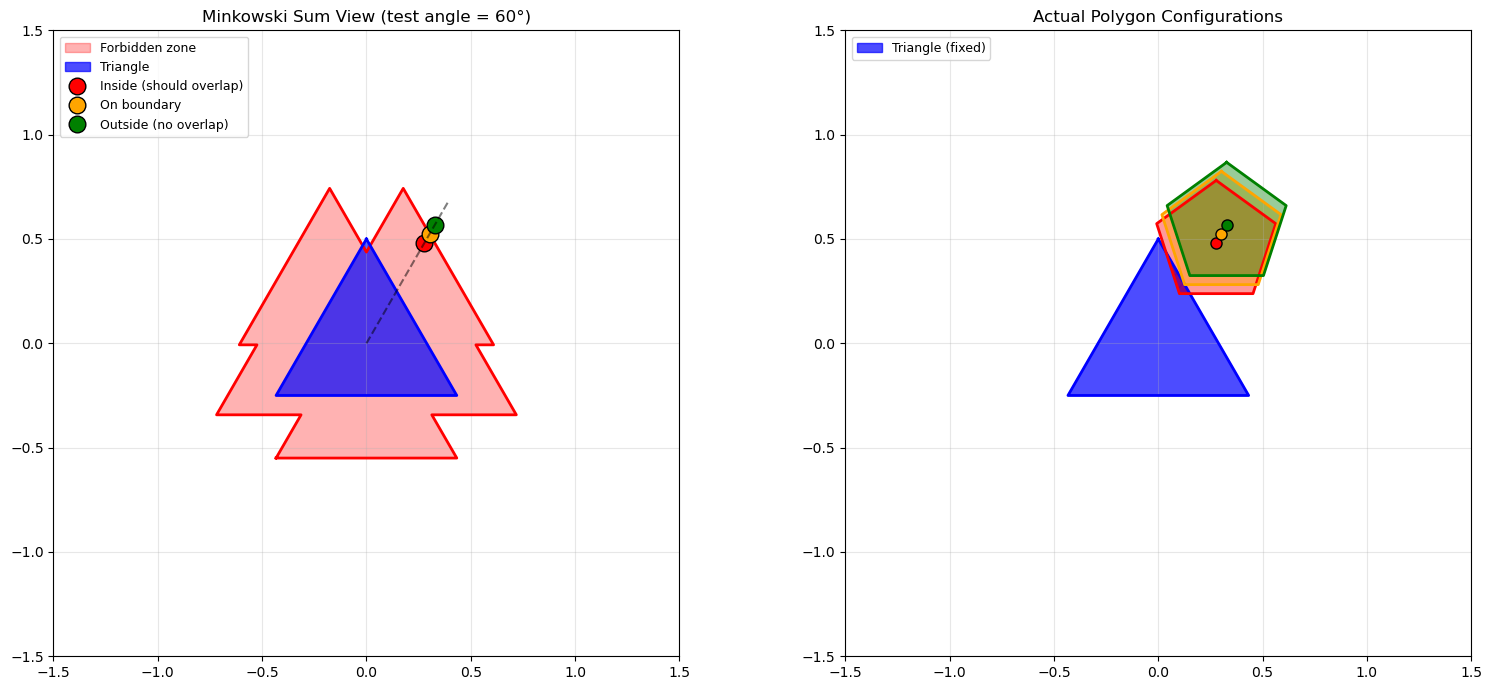


Overlap verification:
  Inside (should overlap):
    Position: (0.2776, 0.4808)
    In Minkowski sum: True
    Actual overlap area: 0.00495186
  On boundary:
    Position: (0.3026, 0.5241)
    In Minkowski sum: False
    Actual overlap area: 0.00000000
  Outside (no overlap):
    Position: (0.3276, 0.5674)
    In Minkowski sum: False
    Actual overlap area: 0.00000000


In [16]:
# Pick a specific angle to visualize in detail
test_angle = np.pi / 3  # 60 degrees

boundary_pt = find_boundary_point(msum, test_angle)
bx, by = boundary_pt
dist = np.sqrt(bx**2 + by**2)
ux, uy = bx/dist, by/dist

epsilon = 0.05  # Larger for visibility

test_points = [
    (bx - epsilon*ux, by - epsilon*uy, 'Inside (should overlap)', 'red'),
    (bx, by, 'On boundary', 'orange'),
    (bx + epsilon*ux, by + epsilon*uy, 'Outside (no overlap)', 'green'),
]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Minkowski sum view
ax = axes[0]
ax.set_aspect('equal')
ax.set_title(f'Minkowski Sum View (test angle = {np.degrees(test_angle):.0f}°)')

# Plot Minkowski sum
x, y = msum.exterior.xy
ax.fill(x, y, alpha=0.3, color='red', label='Forbidden zone')
ax.plot(x, y, 'r-', linewidth=2)

# Plot triangle
x, y = triangle.exterior.xy
ax.fill(x, y, alpha=0.7, color='blue', label='Triangle')
ax.plot(x, y, 'b-', linewidth=2)

# Plot test points
for px, py, label, color in test_points:
    ax.plot(px, py, 'o', markersize=12, color=color, label=label, markeredgecolor='black')

# Draw ray from origin
ax.plot([0, bx*1.3], [0, by*1.3], 'k--', alpha=0.5)

ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# Right: Actual configurations
ax = axes[1]
ax.set_aspect('equal')
ax.set_title('Actual Polygon Configurations')

# Plot triangle
x, y = triangle.exterior.xy
ax.fill(x, y, alpha=0.7, color='blue', label='Triangle (fixed)')
ax.plot(x, y, 'b-', linewidth=2)

# Plot pentagon at each test position
for px, py, label, color in test_points:
    pent_placed = affinity.translate(pentagon, xoff=px, yoff=py)
    x, y = pent_placed.exterior.xy
    ax.fill(x, y, alpha=0.4, color=color)
    ax.plot(x, y, '-', linewidth=2, color=color)
    ax.plot(px, py, 'o', markersize=8, color=color, markeredgecolor='black')
    
    # Check and show overlap
    intersection = triangle.intersection(pent_placed)
    if intersection.area > 0:
        if hasattr(intersection, 'exterior'):
            ix, iy = intersection.exterior.xy
            ax.fill(ix, iy, alpha=0.8, color='purple', hatch='//')

ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

# Print overlap details
print("\nOverlap verification:")
for px, py, label, color in test_points:
    pent_placed = affinity.translate(pentagon, xoff=px, yoff=py)
    intersection = triangle.intersection(pent_placed)
    in_msum = msum.contains(Point(px, py))
    print(f"  {label}:")
    print(f"    Position: ({px:.4f}, {py:.4f})")
    print(f"    In Minkowski sum: {in_msum}")
    print(f"    Actual overlap area: {intersection.area:.8f}")

## Test with Different Polygon Rotations

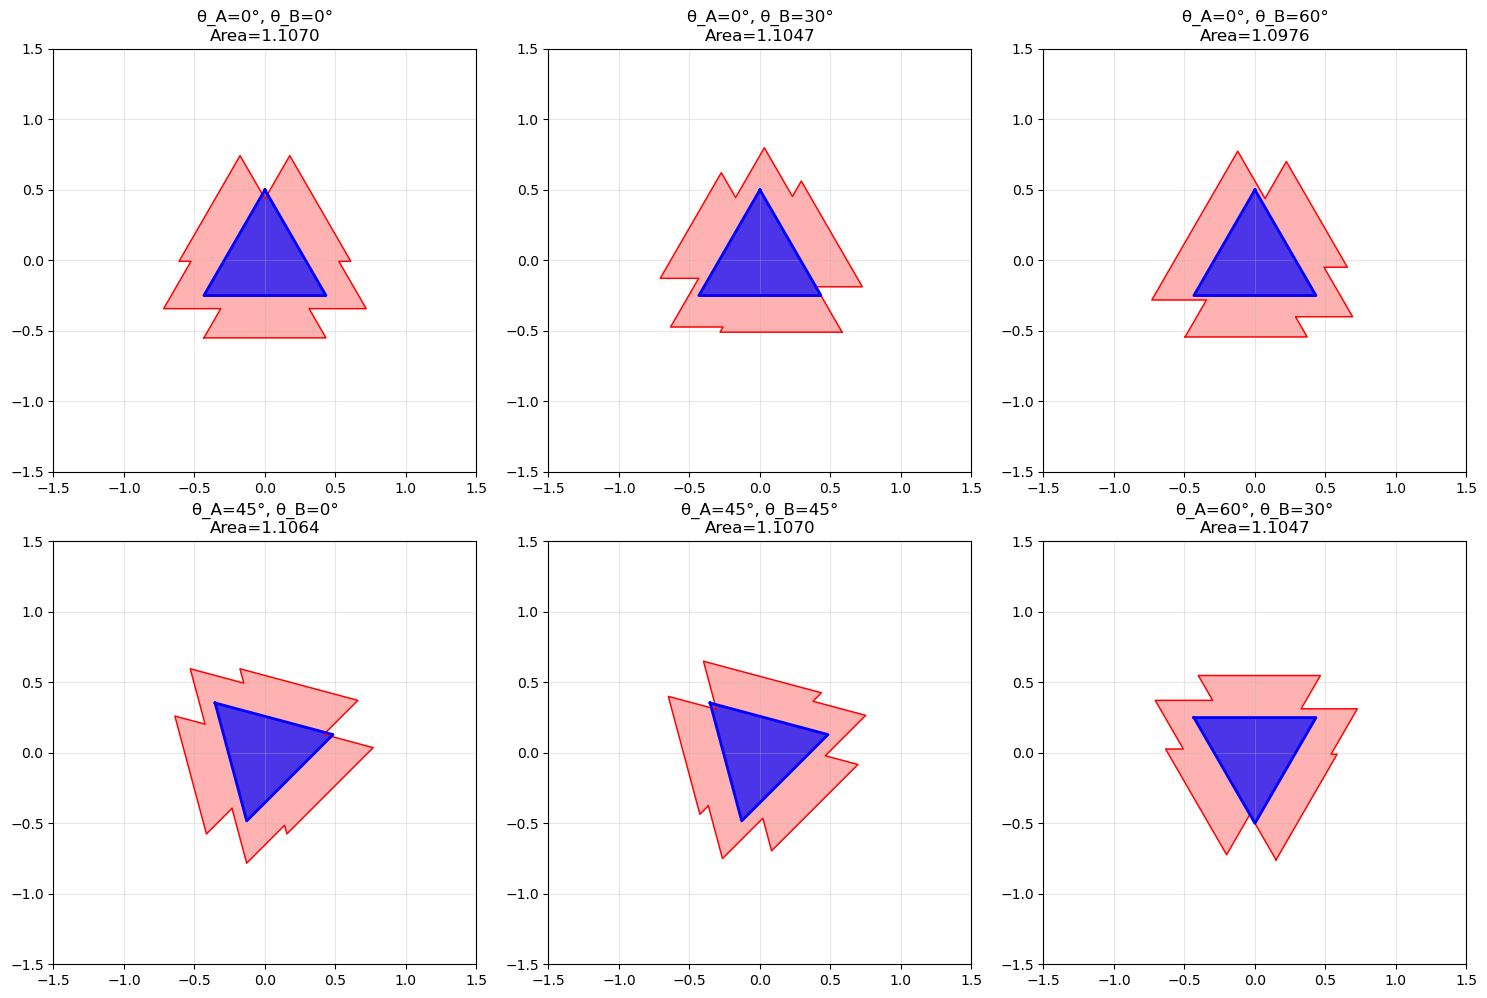

In [17]:
def test_with_rotation(poly_a, poly_b, theta_a, theta_b, ax=None):
    """Test Minkowski sum with rotated polygons."""
    # Rotate polygons
    poly_a_rot = affinity.rotate(poly_a, np.degrees(theta_a), origin=(0, 0))
    poly_b_rot = affinity.rotate(poly_b, np.degrees(theta_b), origin=(0, 0))
    
    # Compute Minkowski difference
    msum = minkowski_difference(poly_a_rot, poly_b_rot)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.set_aspect('equal')
    
    # Plot Minkowski sum
    if isinstance(msum, MultiPolygon):
        for geom in msum.geoms:
            x, y = geom.exterior.xy
            ax.fill(x, y, alpha=0.3, color='red')
            ax.plot(x, y, 'r-', linewidth=1)
    else:
        x, y = msum.exterior.xy
        ax.fill(x, y, alpha=0.3, color='red')
        ax.plot(x, y, 'r-', linewidth=1)
    
    # Plot poly_a at origin
    x, y = poly_a_rot.exterior.xy
    ax.fill(x, y, alpha=0.7, color='blue')
    ax.plot(x, y, 'b-', linewidth=2)
    
    ax.set_title(f'θ_A={np.degrees(theta_a):.0f}°, θ_B={np.degrees(theta_b):.0f}°\nArea={msum.area:.4f}')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    
    return msum


# Test various rotation combinations
rotation_pairs = [
    (0.0, 0.0),
    (0.0, np.pi/6),
    (0.0, np.pi/3),
    (np.pi/4, 0.0),
    (np.pi/4, np.pi/4),
    (np.pi/3, np.pi/6),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (ta, tb) in enumerate(rotation_pairs):
    test_with_rotation(triangle, pentagon, ta, tb, ax=axes[idx])

plt.tight_layout()
plt.show()

## Compute Separation Distance

The separation distance is the signed distance from the relative position to the Minkowski boundary:
- **Positive**: penetration depth (overlapping)
- **Negative**: clearance (not overlapping)

In [18]:
def separation_distance(poly_a, poly_b, pos_a, pos_b, theta_a=0, theta_b=0):
    """
    Compute the exact separation distance between two polygons.
    
    Returns:
        Positive: penetration depth (need to move this far to separate)
        Negative: clearance (can move this far before touching)
    """
    # Rotate polygons
    poly_a_rot = affinity.rotate(poly_a, np.degrees(theta_a), origin=(0, 0))
    poly_b_rot = affinity.rotate(poly_b, np.degrees(theta_b), origin=(0, 0))
    
    # Compute Minkowski difference (centered at poly_a's position)
    msum = minkowski_difference(poly_a_rot, poly_b_rot)
    
    # Relative position of B with respect to A
    dx = pos_b[0] - pos_a[0]
    dy = pos_b[1] - pos_a[1]
    rel_point = Point(dx, dy)
    
    # Distance to boundary
    dist_to_boundary = rel_point.distance(msum.exterior)
    
    # Sign: positive if inside (overlapping), negative if outside
    if msum.contains(rel_point):
        return dist_to_boundary  # Penetration depth
    else:
        return -dist_to_boundary  # Clearance


# Test separation distance
print("Separation Distance Tests:")
print("-" * 70)

test_cases = [
    ((0, 0), (0.3, 0), 0, 0, "Close, likely overlapping"),
    ((0, 0), (0.5, 0), 0, 0, "Medium distance"),
    ((0, 0), (1.0, 0), 0, 0, "Far apart"),
    ((0, 0), (0.4, 0.4), 0, np.pi/4, "Diagonal with rotation"),
]

for pos_a, pos_b, ta, tb, desc in test_cases:
    sep = separation_distance(triangle, pentagon, pos_a, pos_b, ta, tb)
    status = "OVERLAPPING" if sep > 0 else "SEPARATED"
    print(f"{desc}:")
    print(f"  pos_A={pos_a}, pos_B={pos_b}, θ_A={np.degrees(ta):.0f}°, θ_B={np.degrees(tb):.0f}°")
    print(f"  Separation distance: {sep:+.6f} ({status})")
    print()

Separation Distance Tests:
----------------------------------------------------------------------
Close, likely overlapping:
  pos_A=(0, 0), pos_B=(0.3, 0), θ_A=0°, θ_B=0°
  Separation distance: +0.224799 (OVERLAPPING)

Medium distance:
  pos_A=(0, 0), pos_B=(0.5, 0), θ_A=0°, θ_B=0°
  Separation distance: +0.025736 (OVERLAPPING)

Far apart:
  pos_A=(0, 0), pos_B=(1.0, 0), θ_A=0°, θ_B=0°
  Separation distance: -0.390720 (SEPARATED)

Diagonal with rotation:
  pos_A=(0, 0), pos_B=(0.4, 0.4), θ_A=0°, θ_B=45°
  Separation distance: +0.003179 (OVERLAPPING)



## Summary

The Minkowski sum approach works correctly for convex polygons:

1. **Minkowski Sum $M(A, B)$** = Union of A translated by each vertex of B
2. **Minkowski Difference $M(A, -B)$** = Forbidden zone for B's center when A is at origin
3. **Inside the zone** = polygons overlap
4. **Outside the zone** = polygons don't overlap
5. **Distance to boundary** = separation distance (signed)

For **non-convex polygons** (like the tree), the same algorithm works because:
- We still translate A by each vertex of B
- The union captures all possible overlap configurations
- No convex decomposition needed!